# Capture Rate Analysis

This notebook requires about 70GB of storage, and 30-50 GB of RAM.

## Imports and Constants

In [1]:
import datetime as dt
import logging
import os
import shutil
from typing import List

import plotly.express as px
import polars as pl
from nemosis import cache_compiler, defaults, dynamic_data_compiler, static_table
from tqdm import tqdm

In [2]:
start_time = dt.datetime(2014, 1, 1, 0, 5)
end_time = dt.datetime(2024, 12, 31, 23, 55)

start_5ms_date = dt.date(2021, 10, 1)
data_cache = "/home/matthew/Data/capture-rate/"
nemosis_data_cache = "/home/matthew/Data/nemosis/"
aggregated_data_cache = os.path.join(data_cache, "02_aggregated")
sorted_data_cache = os.path.join(data_cache, "03_sorted_compacted")
sorted_rooftop_path = os.path.join(sorted_data_cache, "ROOFTOP_PV_ACTUAL.parquet")
dispatchload_dup_partitioned = os.path.join(data_cache, "05_dispatchload_duplicated_partitioned")
dispatchload_dedup_partitioned = os.path.join(data_cache, "06_dispatchload_deduplicated_partitioned")
dispatchload_dedup = os.path.join(data_cache, "07_dispatchload_dedup_compact.parquet")
results_dir = os.path.join(data_cache, "99_results")
table_names = ["TRADINGPRICE", "DISPATCHPRICE", "DISPATCHLOAD", "ROOFTOP_PV_ACTUAL"]

In [3]:
INTERVALS_PER_H = 60 // 5

In [4]:
fcas_directions = ["RAISE", "LOWER"]
fcas_speeds = ["1SEC", "6SEC", "5MIN", "REG"]

fcas_markets = [d + s for d in fcas_directions for s in fcas_speeds]

In [5]:
logging.getLogger("nemosis").setLevel(logging.WARNING)

In [6]:
color_mapping = {
    "coal": "brown",
    "gas": "black",
    "solar_gridscale": "orange",
    "solar_rooftop": "yellow",
    "wind": "green",
    #"hydro": "blue",
}

In [7]:
gw_per_mw = 1 / 1000

## Download Data

In [8]:
os.makedirs(nemosis_data_cache, exist_ok=True)

In [9]:
# nemosis doesn't include these columns yet
# https://github.com/UNSW-CEEM/NEMOSIS/issues/44
defaults.table_columns["DISPATCHPRICE"] += ["LOWER1SECRRP", "RAISE1SECRRP"]
defaults.table_columns["TRADINGPRICE"] += ["LOWER1SECRRP", "RAISE1SECRRP"]

In [10]:
nemosis_fmt = "%Y/%m/%d %H:%M:%S"

In [11]:

for table in tqdm(table_names):
    cache_compiler(
        start_time.strftime(nemosis_fmt),
        end_time.strftime(nemosis_fmt),
        table,
        nemosis_data_cache,
        keep_csv=True,
        fformat="parquet",
        rebuild=False,
    )

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 3/4 [00:00<00:00,  7.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


## Preprocess Data

We will compact data (squish many small files into one big file).

We'll also parse datetime strings into datetimes, drop `INTERVENTION` columns, deduplicate and interpolate rooftop solar, and sort each dataset individually.

The docs for polars say that you should do one big query, instead of lots of chained queries, so that the optimiser can do it's thing. However in this case that leads to running out of memory on a normal laptop. So we're going to split it up.

The sorting is to make the subsequent `group_by_dynamic` more memory efficient.

In [12]:
def parse_datetimes(
    lf, cols=["SETTLEMENTDATE"], format="%Y/%m/%d %H:%M:%S"
) -> pl.LazyFrame:
    for col in cols:
        lf = lf.with_columns(
            pl.col(col).str.strptime(pl.Datetime(time_unit="ms"), format=format)
        )
    return lf


def list_raw_files(tablename) -> List[str]:
    return [
        os.path.join(nemosis_data_cache, fname)
        for fname in os.listdir(nemosis_data_cache)
        if fname.endswith(".parquet") and (table in fname)
    ]


def drop_intervention(lf) -> pl.LazyFrame:
    if "INTERVENTION" in lf.collect_schema():
        return lf.filter(pl.col("INTERVENTION") == 0).select(pl.exclude("INTERVENTION"))
    else:
        return lf


def scan_raw_table(tablename) -> pl.LazyFrame:
    return pl.concat(
        [(pl.scan_parquet(path)) for path in list_raw_files(tablename)],
        how="diagonal_relaxed",
    )


# requires collecting
def upsample(lf, time_col, group_col="REGIONID") -> pl.DataFrame:
    return (
        lf.sort(time_col, group_col)
        .collect(engine="streaming")
        .upsample(
            time_column=time_col,
            every=dt.timedelta(minutes=5),
            group_by=group_col,
            maintain_order=True,
        )
        .fill_null(strategy="backward", limit=30 // 5 - 1)
    )

In [13]:
os.makedirs(sorted_data_cache, exist_ok=True)

### Dispatchprice and Tradingprice

Compact into one file, because they're small.

In [14]:
table = "TRADINGPRICE"
dest_path = os.path.join(sorted_data_cache, table + ".parquet")
(
    scan_raw_table(table)
    .pipe(parse_datetimes)
    .pipe(drop_intervention)
    .pipe(lambda lf: upsample(lf, time_col="SETTLEMENTDATE"))
    .write_parquet(dest_path)
)

In [15]:
table = "DISPATCHPRICE"
dest_path = os.path.join(sorted_data_cache, table + ".parquet")
(
    scan_raw_table(table)
    .pipe(parse_datetimes)
    .pipe(drop_intervention)
    .sink_parquet(dest_path)
)

### Static Data

Fuel type and region for each generator.



In [16]:
static_pd: "pd.DataFrame" = static_table(
    "Generators and Scheduled Loads", nemosis_data_cache
)

static: pl.LazyFrame = (
    pl.from_pandas(static_pd)
    .lazy()
    # simplify fuel categories
    .with_columns(
        pl.concat_str(
            [
                "Fuel Source - Primary",
                "Technology Type - Descriptor",
                "Fuel Source - Descriptor",
            ],
            separator=" - ",
        )
        .str.to_lowercase()
        .alias("Fuel Detail"),
    )
    .filter(~pl.col("Participant").str.contains("Basslink"))
    .with_columns(
        pl.when(pl.col("Fuel Detail").str.contains("battery"))
        .then(pl.lit("battery"))
        .when(
            pl.col("Fuel Detail").str.contains("hydro")
            & (pl.col("Dispatch Type") == "Load")
        )
        .then(pl.lit("pumps"))
        .when(pl.col("Fuel Detail").str.contains("hydro"))
        .then(pl.lit("hydro"))
        .when(pl.col("Fuel Detail").str.contains("solar"))
        .then(pl.lit("solar_gridscale"))
        .when(pl.col("Fuel Detail").str.contains("wind"))
        .then(pl.lit("wind"))
        .when(pl.col("Fuel Detail").str.contains("waste coal mine gas"))
        .then(pl.lit("coal"))
        .when(
            pl.any_horizontal(
                (
                    pl.col("Fuel Detail").str.contains(s)
                    for s in [
                        "natural gas",
                        "ocgt",
                        "coal seam gas",
                        "coal seam methane",
                    ]
                )
            )
        )
        .then(pl.lit("gas"))
        .when(
            pl.any_horizontal(
                (pl.col("Fuel Detail").str.contains(c))
                # don't blindly search for the word "coal"
                # because coal seam gas should count as gas not coal
                for c in ["black coal", "brown coal"]
            )
        )
        .then(pl.lit("coal"))
        .when(pl.col("Fuel Detail").str.contains("diesel"))
        .then(pl.lit("distillate"))
        .when(pl.col("Fuel Detail").str.contains("biomass"))
        .then(pl.lit("biomass"))
        .when(pl.col("DUID").str.contains("PUMP") & (pl.col("Dispatch Type") == "Load"))
        .then(pl.lit("pumps"))
        .alias("FUEL_TYPE")
    )
    .select("DUID", pl.col("Region").alias("REGIONID"), "FUEL_TYPE")
)

# check we've categorised everything
assert not static.select(
    pl.col("FUEL_TYPE").is_null().any().alias("UNKNOWN")
).collect(engine="streaming")["UNKNOWN"][0]

### Dispatchload

First we need to deduplicate it. We do this by partitioning by DUID. This is slow, but necessary. (Otherwise we need > 200GB of RAM. Also some DUIDs have `/` and `#` in them. Also the total number of partitions is in the hundreds, which some tools (e.g. pyarrow) can't handle.)

In [17]:
table = "DISPATCHLOAD"

In [18]:
dispatchload_duped = (
    pl.scan_parquet(list_raw_files(table), low_memory = True, missing_columns='insert', extra_columns='ignore')
    .pipe(parse_datetimes)
    .pipe(drop_intervention)
    .select("SETTLEMENTDATE", "INITIALMW", "TOTALCLEARED", "DUID", "AVAILABILITY")
)

duids = dispatchload_duped.select("DUID").unique().collect(engine="streaming").to_series().to_list()

dispatchload_dup_partitioned = os.path.join(data_cache, "05_dispatchload_duplicated_partitioned")
dispatchload_dedup_partitioned = os.path.join(data_cache, "06_dispatchload_deduplicated_partitioned")

In [19]:
[d for d in duids if '/' in d]

['W/HOE#2', 'W/HOE#1']

In [20]:
paths = {}

# partition
for duid in tqdm(duids):
    # watch out, some duids contain / and #
    # This should still just work though
    dest_path = os.path.join(dispatchload_dup_partitioned, duid + ".parquet")
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    if not os.path.exists(dest_path):
        (
            dispatchload_duped
            .filter(pl.col("DUID") == duid)
            .select(pl.exclude("DUID"))
            .sink_parquet(dest_path)
        )
    paths[duid] = {'duplicated': dest_path}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 585/585 [02:49<00:00,  3.44it/s]


In [21]:
# deduplicate
for duid in tqdm(duids):
    # watch out, some duids contain / and #
    # This should still just work though
    src_path = paths[duid]['duplicated']
    dest_path = os.path.join(dispatchload_dedup_partitioned, duid + ".parquet")
    paths[duid]['deduplicated'] = dest_path
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    if not os.path.exists(dest_path):
        (
            pl.scan_parquet(src_path, low_memory=True)
            .group_by("SETTLEMENTDATE")
            .first()
            .sink_parquet(dest_path)
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 585/585 [00:25<00:00, 22.80it/s]


In [60]:
# compact
lfs = []
for (duid, ps) in paths.items():
    lf = (
        pl.scan_parquet(ps['deduplicated'])
        .with_columns(pl.lit(duid).alias("DUID"))
    )
    lfs.append(lf)
(
    pl.concat(lfs, how='diagonal_relaxed')
    .sink_parquet(dispatchload_dedup)
)

In [23]:
dispatchload_dedup

'/home/matthew/Data/nem-capture-rate/07_dispatchload_dedup_compact.parquet'



We'll join this to static data to get region and fuel type. Then compact into one row per (time interval, fuel type, region).

This first cell deduplicates the data. Since sometimes DISPATCHLOAD files are duplicated across months.
This requires about 150GB of memory. If you don't have that, use the 2 following cells instead. (Commented out.)

In [24]:

# dest_path = os.path.join(sorted_data_cache, table + ".parquet")


# (
#     pl.scan_parquet(list_raw_files(table), low_memory = True, missing_columns='insert', extra_columns='ignore')
#     .pipe(parse_datetimes)
#     .pipe(drop_intervention)
#     # dedup - very memory intense
#     .group_by("DUID", "SETTLEMENTDATE")
#     .first()

#     # aggregate by fuel type
#     .join(static, on="DUID")
#     .with_columns(
#         pl.col("FUEL_TYPE").fill_null(value="UNKNOWN"),
#         pl.mean_horizontal("INITIALMW", "TOTALCLEARED").alias("POWER"),
#     )
#     .group_by("SETTLEMENTDATE", "REGIONID", "FUEL_TYPE")
#     .agg(
#         pl.col("POWER").sum(),
#         #pl.col(present_fcas_cols).sum(),
#     )
#     .sink_parquet(dest_path)
# )

In [25]:
# table = "DISPATCHLOAD"

# dest_dir = os.path.join(aggregated_data_cache, table)
# shutil.rmtree(dest_dir, ignore_errors=True)
# os.makedirs(dest_dir)


# agged_files = []

# for source_path in tqdm(list_raw_files(table)):
#     assert os.path.exists(source_path), f"Source path doesn't exist: {source_path}"
#     dest_path = os.path.join(dest_dir, os.path.basename(source_path))
#     assert source_path != dest_path
#     agged_files.append(dest_path)

#     try:
#         schema = pl.read_parquet_schema(source_path)
#         present_fcas_cols = [c for c in fcas_markets if c in schema]
#         (
#             pl.scan_parquet(source_path)
#             .pipe(drop_intervention)
#             .join(static, on="DUID")
#             .with_columns(
#                 pl.col("FUEL_TYPE").fill_null(value="UNKNOWN"),
#                 pl.mean_horizontal("INITIALMW", "TOTALCLEARED").alias("POWER"),
#             )
#             .group_by("SETTLEMENTDATE", "REGIONID", "FUEL_TYPE")
#             .agg(
#                 pl.col("POWER").sum(),
#                 pl.col(present_fcas_cols).sum(),
#             )
#             .pipe(parse_datetimes)
#             .sink_parquet(dest_path)
#         )
#     except Exception:
#         print(f"Error with {source_path}")
#         if os.path.exists(dest_path):
#             os.remove(dest_path)
#         raise

After aggregating by fuel type (and region), now we have lots of tiny files we can compact into one.

(`scan_parquet` with a glob pattern doesn't always work, because of schema mismatches.)

In [26]:
# dest_path = os.path.join(sorted_data_cache, table + ".parquet")
# (
#     pl.concat(
#         [pl.scan_parquet(f) for f in agged_files], how="diagonal_relaxed"
#     )
#     .sink_parquet(dest_path)
# )

### Rooftop Data

In [27]:
table = "ROOFTOP_PV_ACTUAL"
rooftop_duplicated = scan_raw_table(table)

rooftop_duplicated.head().collect(engine="streaming")

INTERVAL_DATETIME,REGIONID,POWER,QI,TYPE,LASTCHANGED
str,str,f64,f64,str,str
"""2020/12/01 00:30:00""","""NSW1""",0.0,1.0,"""MEASUREMENT""","""2020/12/01 00:50:25"""
"""2020/12/01 00:30:00""","""NSW1""",0.0,0.6,"""SATELLITE""","""2020/12/01 00:50:32"""
"""2020/12/01 00:30:00""","""QLD1""",0.0,1.0,"""MEASUREMENT""","""2020/12/01 00:50:25"""
"""2020/12/01 00:30:00""","""QLD1""",0.0,0.6,"""SATELLITE""","""2020/12/01 00:50:32"""
"""2020/12/01 00:30:00""","""QLDC""",0.0,1.0,"""MEASUREMENT""","""2020/12/01 00:50:25"""


In [28]:
# deduplicate across the different methods of estimation
rooftop_30 = (
    rooftop_duplicated.pipe(drop_intervention)
    .filter(pl.col("REGIONID").str.ends_with("1"))
    # deduplicate
    .sort(by=["TYPE", "QI", "LASTCHANGED"], descending=[False, True, True])
    .group_by(["REGIONID", "INTERVAL_DATETIME"])
    .first()
    .select(["REGIONID", "INTERVAL_DATETIME", "POWER"])
    .rename({"INTERVAL_DATETIME": "INTERVAL_END"})
)

In [29]:
# now interpolate rooftop solar from 30 minutes to 5

(
    rooftop_30
    .pipe(lambda lf: parse_datetimes(lf, cols=["INTERVAL_END"]))
    .pipe(lambda lf: upsample(lf, time_col="INTERVAL_END"))
    .filter(pl.col("REGIONID").is_not_null())
    .write_parquet(sorted_rooftop_path)
)

## Scan Data

In [61]:
dispatchprice = pl.scan_parquet(
    os.path.join(sorted_data_cache, "DISPATCHPRICE.parquet"), low_memory=True
)
assert "INTERVENTION" not in dispatchprice.collect_schema()
dispatchprice.head().collect(engine="streaming")

SETTLEMENTDATE,REGIONID,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,PRICE_STATUS,RAISE1SECRRP,LOWER1SECRRP
datetime[ms],str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64
2017-02-01 00:05:00,"""NSW1""",55.94,1.4,1.0,1.2,7.4,0.02,0.06,0.17,9.0,"""FIRM""",null,null
2017-02-01 00:05:00,"""QLD1""",59.64289,1.4,1.0,1.2,7.4,0.02,0.06,0.17,9.0,"""FIRM""",null,null
2017-02-01 00:05:00,"""SA1""",42.22689,1.4,1.0,1.2,7.4,0.02,0.06,0.17,9.0,"""FIRM""",null,null
2017-02-01 00:05:00,"""TAS1""",73.9,5.0,2.39,1.2,15.0,0.0,0.0,0.0,0.1,"""FIRM""",null,null
2017-02-01 00:05:00,"""VIC1""",35.21009,1.4,1.0,1.2,7.4,0.02,0.06,0.17,9.0,"""FIRM""",null,null


In [62]:
tradingprice = pl.scan_parquet(
    os.path.join(sorted_data_cache, "*TRADINGPRICE*.parquet"), low_memory=True
)
assert "INTERVENTION" not in tradingprice.collect_schema()
tradingprice.head().collect(engine="streaming")

SETTLEMENTDATE,REGIONID,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,PRICE_STATUS,RAISE1SECRRP,LOWER1SECRRP
datetime[ms],str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64
2013-12-01 00:30:00,"""NSW1""",48.98,0.21,0.17,0.63,0.63,0.2,0.18,0.27,0.27,"""FIRM""",null,null
2013-12-01 00:35:00,"""NSW1""",47.79,0.41,0.17,0.68,1.0,0.09,0.18,0.27,0.63,"""FIRM""",null,null
2013-12-01 00:40:00,"""NSW1""",47.79,0.41,0.17,0.68,1.0,0.09,0.18,0.27,0.63,"""FIRM""",null,null
2013-12-01 00:45:00,"""NSW1""",47.79,0.41,0.17,0.68,1.0,0.09,0.18,0.27,0.63,"""FIRM""",null,null
2013-12-01 00:50:00,"""NSW1""",47.79,0.41,0.17,0.68,1.0,0.09,0.18,0.27,0.63,"""FIRM""",null,null


In [63]:
actual = (
    tradingprice.select(
        (pl.col("SETTLEMENTDATE").shift(-1) - pl.col("SETTLEMENTDATE")).alias(
            "INTERVAL_LENGTH"
        )
    )
    .head(1)
    .collect(engine="streaming")
    .item()
)
expected = dt.timedelta(minutes=5)
assert actual == expected, "tradingprice not upsampled"

In [64]:
rooftop = pl.scan_parquet(sorted_rooftop_path, low_memory=True)
assert "INTERVENTION" not in rooftop.collect_schema()
rooftop.head().collect(engine="streaming")

INTERVAL_END,REGIONID,POWER
datetime[ms],str,f64
2016-08-01 00:30:00,"""NSW1""",0.0
2016-08-01 00:35:00,"""NSW1""",0.0
2016-08-01 00:40:00,"""NSW1""",0.0
2016-08-01 00:45:00,"""NSW1""",0.0
2016-08-01 00:50:00,"""NSW1""",0.0


In [135]:
source_path = dispatchload_dedup

dispatchload = (
    pl.scan_parquet(source_path, low_memory=True)
    .rename({"SETTLEMENTDATE": "INTERVAL_END"})
    .with_columns(
        pl.mean_horizontal("INITIALMW", "TOTALCLEARED").alias("POWER")
    )
    .join(static, on="DUID")
)
assert "INTERVENTION" not in dispatchload.collect_schema()
dispatchload.head().collect(engine="streaming")

INTERVAL_END,INITIALMW,TOTALCLEARED,AVAILABILITY,DUID,POWER,REGIONID,FUEL_TYPE
datetime[ms],f64,f64,f64,str,f64,str,str
2022-04-11 23:35:00,7.14,8.065,8.065,"""KEPWF1""",7.6025,"""QLD1""","""wind"""
2022-04-12 01:00:00,9.8,10.0,10.0,"""KEPWF1""",9.9,"""QLD1""","""wind"""
2022-04-12 04:25:00,9.79,10.0,10.0,"""KEPWF1""",9.895,"""QLD1""","""wind"""
2022-04-12 05:20:00,9.85,10.0,10.0,"""KEPWF1""",9.925,"""QLD1""","""wind"""
2022-04-12 06:55:00,0.0,0.0,0.0,"""KEPWF1""",0.0,"""QLD1""","""wind"""


Resistor Revenue

In [66]:
neg_results = (
    dispatchprice
    .filter(pl.col("RRP") < 0)
    .sort("SETTLEMENTDATE")
    .group_by_dynamic("SETTLEMENTDATE", every="1mo", group_by="REGIONID")
    .agg(
        (-pl.col("RRP") / INTERVALS_PER_H).sum().alias("REVENUE")
    )
    .collect(engine="streaming")
)

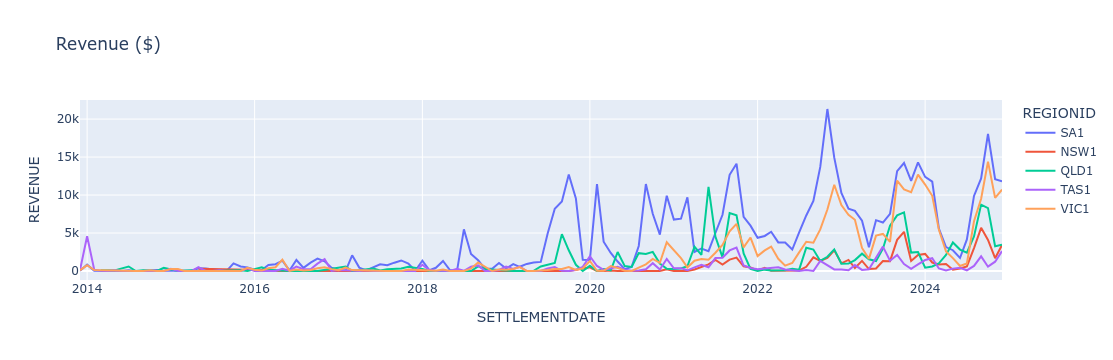

In [67]:

fig = px.line(
    neg_results,
    x="SETTLEMENTDATE",
    y="REVENUE",
    color="REGIONID",
    title=f"Revenue ($)"
)

#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

## Computation

In [37]:
figures = {}

### Capture Price Ratio

In [168]:
os.makedirs(results_dir, exist_ok=True)

* dispatchload joined with static
* concat with rooftop
* join with prices
* capture rate over time
* plot

In [169]:
regionid_enum = pl.Enum(["QLD1", "NSW1", "VIC1", "TAS1", "SA1"])
fuel_type_enum = pl.Enum(
    [
        "gas",
        "coal",
        "solar_rooftop",
        "solar_gridscale",
        "wind",
        "hydro",
        "distillate",
        "pumps",
        "battery",
    ]
)

In [170]:
(
    dispatchload
    .head()
    .collect(engine='streaming')
)

INTERVAL_END,INITIALMW,TOTALCLEARED,AVAILABILITY,DUID,POWER,REGIONID,FUEL_TYPE
datetime[ms],f64,f64,f64,str,f64,str,str
2021-01-18 20:50:00,9.26898,9.611,9.611,"""GULLRWF2""",9.43999,"""NSW1""","""wind"""
2021-01-18 21:50:00,11.29053,12.267,12.267,"""GULLRWF2""",11.778765,"""NSW1""","""wind"""
2021-01-18 22:10:00,12.3175,13.743,13.743,"""GULLRWF2""",13.03025,"""NSW1""","""wind"""
2021-01-18 23:05:00,13.88402,14.267,14.267,"""GULLRWF2""",14.07551,"""NSW1""","""wind"""
2021-01-19 01:25:00,1.586,1.03,1.03,"""GULLRWF2""",1.308,"""NSW1""","""wind"""


In [171]:
def calculate(metric):
    return (
        pl.concat(
            [
                dispatchload,
                (rooftop.with_columns(pl.lit("solar_rooftop").alias("FUEL_TYPE"))),
            ],
            how="diagonal_relaxed",
        )
        .with_columns((pl.col("POWER") / INTERVALS_PER_H).alias("ENERGY_MWH"))
        .cast(
            {
                "REGIONID": regionid_enum,
                "FUEL_TYPE": fuel_type_enum,
            }
        )
        .join(
            tradingprice.with_columns(
                pl.col("SETTLEMENTDATE").alias("INTERVAL_END"),
                pl.col("RRP").alias("ENERGY_PRICE"),
            ).cast(
                {
                    "REGIONID": regionid_enum,
                }
            ),
            on=["REGIONID", "INTERVAL_END"],
        )
        .with_columns(
            [
                (pl.col("POWER") * pl.col("RRP") / INTERVALS_PER_H).alias("ENERGY_REVENUE"),
                # (
                #     pl.sum_horizontal([pl.col(m) * pl.col(m + "RRP") for m in fcas_markets])
                #     / INTERVALS_PER_H
                # ).alias("FCAS_REVENUE"),
            ]
        )
        .with_columns(
            #(pl.col("ENERGY_REVENUE") + pl.col("FCAS_REVENUE")).alias("TOTAL_REVENUE")
            pl.col("ENERGY_REVENUE").alias("TOTAL_REVENUE")
        )
        .with_columns(
            pl.col("ENERGY_MWH")
            .sum()
            .over("REGIONID", "INTERVAL_END")
            .alias("REGION_INTERVAL_MWH"),
            pl.col("TOTAL_REVENUE")
            .sum()
            .over("REGIONID", "INTERVAL_END")
            .alias("REGION_INTERVAL_REVENUE"),
        )
        .sort("INTERVAL_END")
        .group_by_dynamic(
            index_column="INTERVAL_END",
            every="1y",
            label="left",
            group_by=["FUEL_TYPE"],  # "REGIONID",
        )
        .agg(
            pl.col("ENERGY_PRICE").mean().alias("TWAP"),
            pl.col("REGION_INTERVAL_REVENUE").sum().alias("REGION_REVENUE"),
            pl.col("REGION_INTERVAL_MWH").sum().alias("REGION_MWH"),
            (pl.col("TOTAL_REVENUE").sum() / pl.col("ENERGY_MWH").sum()).alias(
                "CAPTURE_PRICE"
            ),
            pl.len().alias("N"),
        )
        .rename({"INTERVAL_END": "INTERVAL_START"})
        .filter(
            pl.col("N") > 24 * INTERVALS_PER_H
        )  # remove end periods with only a few samples
        .with_columns(
            (pl.col("REGION_REVENUE") / pl.col("REGION_MWH")).alias("REGION_GWAP")
        )
        .with_columns(
            (pl.col("CAPTURE_PRICE") / pl.col("TWAP")).alias("CAPTURE_RATIO"),
            (pl.col("CAPTURE_PRICE") / pl.col("REGION_GWAP")).alias("PARTICIPATION_FACTOR"),
        )
        .select("INTERVAL_START", "FUEL_TYPE", metric)
        .sort("INTERVAL_START", "FUEL_TYPE")  # "REGIONID",
        .collect(engine="streaming")
    )


In [172]:
df_pf = calculate("PARTICIPATION_FACTOR")
df_pf.write_csv(os.path.join(results_dir, f"results-participation-factor.csv"))

In [173]:
df_cr = calculate("CAPTURE_RATIO")
df_cr.write_csv(os.path.join(results_dir, f"results-capture-rate.csv"))

In [174]:
# 
(
    df_cr
    .filter(pl.col("INTERVAL_START").dt.year() == 2024)
    .sort("CAPTURE_RATIO")
)

INTERVAL_START,FUEL_TYPE,CAPTURE_RATIO
datetime[ms],enum,f64
2024-01-01 00:00:00,"""battery""",-6.577636
2024-01-01 00:00:00,"""pumps""",0.173503
2024-01-01 00:00:00,"""solar_rooftop""",0.292171
2024-01-01 00:00:00,"""solar_gridscale""",0.459483
2024-01-01 00:00:00,"""wind""",0.76035
2024-01-01 00:00:00,"""coal""",1.139197
2024-01-01 00:00:00,"""hydro""",1.847819
2024-01-01 00:00:00,"""gas""",2.55109
2024-01-01 00:00:00,"""distillate""",18.26248


In [176]:
df_cp = calculate("CAPTURE_PRICE")
df_cp.write_csv(os.path.join(results_dir, f"results-cp.csv"))


In [177]:
# "In 2024 gridscale solar power was solar for an average of x \$/MWh , compared to y \$/MWh for gas."
(
    df_cp
    .filter(pl.col("INTERVAL_START").dt.year() == 2024)
    .sort("CAPTURE_PRICE")
)

INTERVAL_START,FUEL_TYPE,CAPTURE_PRICE
datetime[ms],enum,f64
2024-01-01 00:00:00,"""battery""",-646.567666
2024-01-01 00:00:00,"""pumps""",20.860496
2024-01-01 00:00:00,"""solar_rooftop""",30.420047
2024-01-01 00:00:00,"""solar_gridscale""",51.479566
2024-01-01 00:00:00,"""wind""",76.824434
2024-01-01 00:00:00,"""coal""",124.416964
2024-01-01 00:00:00,"""hydro""",187.110093
2024-01-01 00:00:00,"""gas""",259.641977
2024-01-01 00:00:00,"""distillate""",1968.105304


/tmp/ipykernel_2222/1216693976.py:42: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




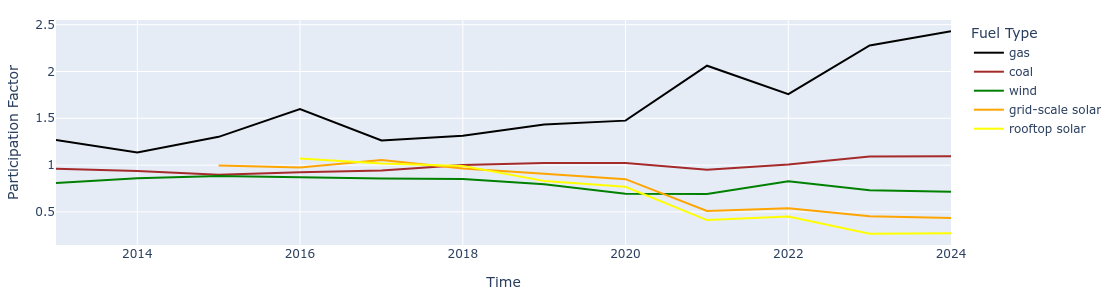

/tmp/ipykernel_2222/1216693976.py:42: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




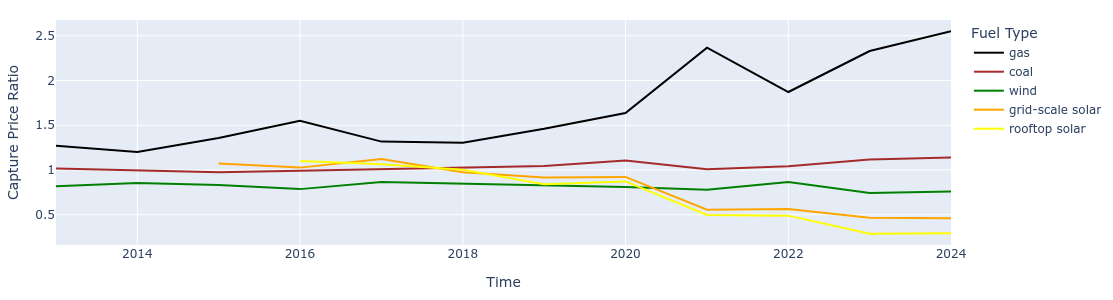

In [178]:


metrics = [
    {
        'df': df_pf,
        'title': "Participation Factor",
        'col': "PARTICIPATION_FACTOR",
    },
    {
        'df': df_cr,
        'title': "Capture Price Ratio",
        'col': "CAPTURE_RATIO",
    },
]

for metric in metrics:

    fig = px.line(
        metric['df'].filter(pl.col("FUEL_TYPE").is_in(color_mapping)),
        x="INTERVAL_START",
        y=metric['col'],
        color="FUEL_TYPE",
        color_discrete_map=color_mapping,
        height=300,
        width=600,
        #title=f"{metric['title']} over time by fuel type (whole NEM)",
        labels={
            "FUEL_TYPE": "Fuel Type",
            "INTERVAL_START": "Time",
            metric['col']: metric['title'],
        }
    )

    fig.update_yaxes(range=[0, None])
    fig.for_each_trace(lambda t: t.update(name=t.name
        .replace("solar_gridscale", "grid-scale solar")
        .replace("solar_rooftop", "rooftop solar")
    ))
    
    #fig.update_layout(yaxis_tickformat = '.0%')
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    slug = metric['col'] #metric['title'].replace(' ', '_')
    fig.update_layout(margin=dict(l=20, r=20, t=20, b=20))
    fig.write_image(os.path.join(results_dir, f"{slug}.svg"))
    
    fig.show()

    figures[metric['col']] = fig

In [180]:
# same again, but just solar in VIC and SA

df_solar = (
    pl.concat(
        [
            dispatchload
            #.rename({"SETTLEMENTDATE": "INTERVAL_END"})
            .filter(pl.col("FUEL_TYPE") == "solar_gridscale"),
            (rooftop.with_columns(pl.lit("solar_rooftop").alias("FUEL_TYPE"))),
        ],
        how="diagonal_relaxed",
    )
    .filter((pl.col("REGIONID") == "SA1") | (pl.col("REGIONID") == "VIC1"))
    .with_columns((pl.col("POWER") / INTERVALS_PER_H).alias("ENERGY_MWH"))
    .cast(
        {
            "REGIONID": regionid_enum,
            "FUEL_TYPE": fuel_type_enum,
        }
    )
    .join(
        tradingprice.with_columns(
            pl.col("SETTLEMENTDATE").alias("INTERVAL_END"),
            pl.col("RRP").alias("ENERGY_PRICE"),
        ).cast(
            {
                "REGIONID": regionid_enum,
            }
        ),
        on=["REGIONID", "INTERVAL_END"],
    )
    .with_columns(
        [
            (pl.col("POWER") * pl.col("RRP") / INTERVALS_PER_H).alias("ENERGY_REVENUE"),
            # (
            #     pl.sum_horizontal([pl.col(m) * pl.col(m + "RRP") for m in fcas_markets])
            #     / INTERVALS_PER_H
            # ).alias("FCAS_REVENUE"),
        ]
    )
    .with_columns(
        pl.col("ENERGY_REVENUE").alias("TOTAL_REVENUE")
        #(pl.col("ENERGY_REVENUE") + pl.col("FCAS_REVENUE")).alias("TOTAL_REVENUE")
    )
    .with_columns(
        pl.col("ENERGY_MWH")
        .sum()
        .over("REGIONID", "INTERVAL_END")
        .alias("REGION_INTERVAL_MWH"),
        pl.col("TOTAL_REVENUE")
        .sum()
        .over("REGIONID", "INTERVAL_END")
        .alias("REGION_INTERVAL_REVENUE"),
    )
    .sort("INTERVAL_END")
    .group_by_dynamic(
        index_column="INTERVAL_END",
        every="3mo",
        label="left",
        group_by=["FUEL_TYPE", "REGIONID"],  # "REGIONID",
    )
    .agg(
        pl.col("ENERGY_PRICE").mean().alias("TWAP"),
        pl.col("REGION_INTERVAL_REVENUE").sum().alias("REGION_REVENUE"),
        pl.col("REGION_INTERVAL_MWH").sum().alias("REGION_MWH"),
        (pl.col("TOTAL_REVENUE").sum() / pl.col("ENERGY_MWH").sum()).alias(
            "CAPTURE_PRICE"
        ),
        pl.len().alias("N"),
    )
    .rename({"INTERVAL_END": "INTERVAL_START"})
    .filter(
        pl.col("N") > 24 * INTERVALS_PER_H
    )  # remove end periods with only a few samples
    .with_columns(
        (pl.col("REGION_REVENUE") / pl.col("REGION_MWH")).alias("REGION_GWAP")
    )
    .with_columns(
        (pl.col("CAPTURE_PRICE") / pl.col("TWAP")).alias("CAPTURE_RATIO"),
        (pl.col("CAPTURE_PRICE") / pl.col("REGION_GWAP")).alias("PARTICIPATION_FACTOR"),
    )
    .select("INTERVAL_START", "FUEL_TYPE", "CAPTURE_RATIO", "REGIONID")
    .sort("INTERVAL_START", "FUEL_TYPE")  # "REGIONID",
    .collect(engine="streaming")
)


/tmp/ipykernel_2222/364703471.py:20: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




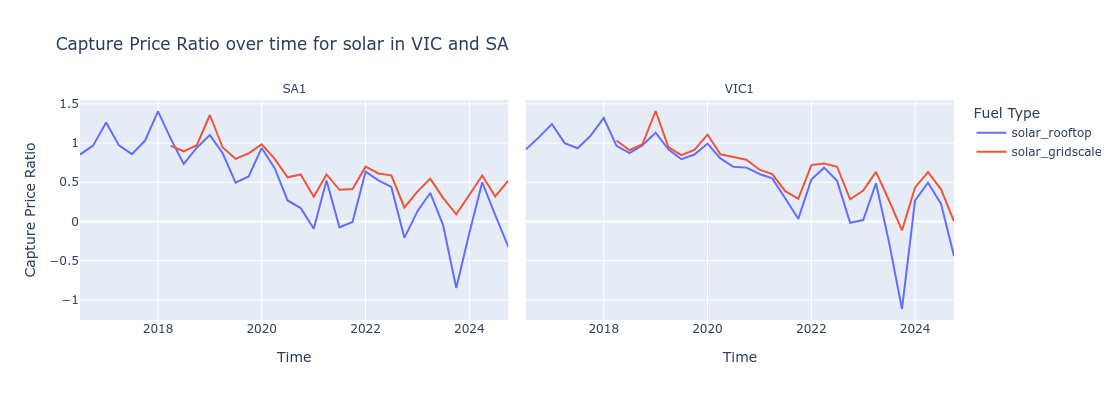

In [181]:

fig = px.line(
    df_solar,
    x="INTERVAL_START",
    y="CAPTURE_RATIO",
    color="FUEL_TYPE",
    #color_discrete_map=color_mapping,
    facet_col="REGIONID",
    height=400,
    width=800,
    title=f"{metric['title']} over time for solar in VIC and SA",
    labels={
        "FUEL_TYPE": "Fuel Type",
        "INTERVAL_START": "Time",
        "CAPTURE_RATIO": "Capture Price Ratio",
        "REGIONID": "Region"
    }
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.write_image(os.path.join(results_dir, f"vic-sa-solar.svg"))

fig.show()

### Capacity Factor

I want to plot the capacity factor (% of max MWh) by fuel type, over time.

We have the MWh (or MW) each generator actually produced.
We need the maximum capacity of each generator. Since generators come and go, but we don't want to reduce the amount for maintenance outages, we'll do a per-generator aggregation based on actual observed output.


In [182]:
threshold = 0.05

Start with non-rooftop solar

In [183]:
dispatchload = (
    pl.scan_parquet(os.path.join(nemosis_data_cache, "*DISPATCHLOAD*.parquet"), low_memory=True)
    .pipe(drop_intervention)
    .pipe(parse_datetimes)
    .with_columns(
        pl.col("SETTLEMENTDATE").dt.date().alias("DATE"),
        pl.mean_horizontal("TOTALCLEARED", "INITIALMW").alias("POWER")
    )
    # dedup
    # very memory intensive
    .group_by("DUID", "SETTLEMENTDATE")
    .first()
    .select("DUID", "SETTLEMENTDATE", "POWER", "AVAILABILITY")
)

In [184]:
# # dedup dispatchload
# (
#     dispatchload
#     .group_by("DUID", "SETTLEMENTDATE")
#     .first()
#     .select("DUID", "SETTLEMENTDATE", "POWER", "AVAILABILITY")
#     .sink_parquet(dispatchload_dedup)
# )

In [185]:
# dispatchload = pl.scan_parquet(dispatchload_dedup, low_memory=True)

In [186]:
# what is the max availability over all time per duid
# this gives us the installed capacity

static_max = (
    dispatchload
    .group_by("DUID")
    .agg(pl.col("AVAILABILITY").max().alias("MAX_CAPACITY"))
)

In [187]:
# when was the first time each generator generated at least 5% of that?
# We'll call that the comissioning start date (and end date)

start_end = (
    dispatchload
    .join(static_max, how="inner", on="DUID")
    .filter(pl.col("AVAILABILITY") >= threshold * pl.col("MAX_CAPACITY"))
    .group_by("DUID", "MAX_CAPACITY")
    .agg(
        pl.col("SETTLEMENTDATE").min().alias("START_DATE"),
        pl.col("SETTLEMENTDATE").max().alias("END_DATE"),
    )
)

In [188]:
# have we had any retirements?
(
    start_end
    .join(static, on="DUID")
    .filter(pl.col("FUEL_TYPE").is_in(["coal", "gas"]))
    .sort("END_DATE")
    .join(static_max, how="inner", on="DUID")
    .filter(pl.col("END_DATE") < end_time - dt.timedelta(days=1))
    .select("DUID", "FUEL_TYPE", "START_DATE", "END_DATE", "MAX_CAPACITY")
    .sort("END_DATE")
    .collect(engine="streaming")
)

DUID,FUEL_TYPE,START_DATE,END_DATE,MAX_CAPACITY
str,str,datetime[ms],datetime[ms],f64
"""TORRB1""","""gas""",2013-12-01 00:05:00,2021-09-30 20:30:00,210.0
"""BBTHREE3""","""gas""",2013-12-01 00:05:00,2023-10-11 12:15:00,40.0
"""POR01""","""gas""",2013-12-01 00:05:00,2024-07-01 04:00:00,50.0
"""POR03""","""gas""",2013-12-01 00:05:00,2024-07-01 04:00:00,23.0
"""SNUG1""","""gas""",2013-12-01 00:05:00,2024-07-01 04:00:00,67.0
…,…,…,…,…
"""CPSA""","""gas""",2013-12-10 12:35:00,2024-12-29 21:00:00,144.0
"""YABULU2""","""gas""",2014-01-02 10:20:00,2024-12-30 21:10:00,84.0
"""YABULU""","""gas""",2013-12-01 00:05:00,2024-12-30 21:30:00,174.0


In [189]:
# filter in only those intervals between start and end comissioning dates
# and add fuel type
dl_filtered = (
    dispatchload
    .join_where(
        start_end,
        (pl.col("DUID") == pl.col("DUID_right")) &
        (pl.col("SETTLEMENTDATE") >= pl.col("START_DATE")) &
        (pl.col("SETTLEMENTDATE") <= pl.col("END_DATE")),
        suffix="_right"
    )
    .drop("DUID_right", "START_DATE", "END_DATE")
    .join(static, on="DUID")
    .with_columns(
        pl.col("FUEL_TYPE").fill_null(value="UNKNOWN"),
    )
    # sum generators (DUID) together, to aggregate to fuel type
    .group_by("FUEL_TYPE", pl.col("SETTLEMENTDATE").alias("INTERVAL_END"))
    .agg(
        pl.col("POWER").sum(),
        #pl.col("MAX_CAPACITY").sum(), # based on start/end date
        pl.col("AVAILABILITY").sum().alias("MAX_CAPACITY") # based on max availability these 3 months
    )
)

# now we have INTERVAL_END, FUEL_TYPE, POWER, MAX_CAPACITY
# for everything except rooftop solar

In [190]:
# find max capacity of rooftop solar
# just use cumulative sum

solar_power_and_capacity = (    
    pl.scan_parquet(sorted_rooftop_path)
    .group_by("INTERVAL_END")
    .agg(
        pl.col("POWER").sum()
    )
    .sort("INTERVAL_END")
    .select(
        "INTERVAL_END",
        "POWER",
        pl.col("POWER").cum_max().alias("MAX_CAPACITY")
    )
    .with_columns(
        pl.lit("solar_rooftop").alias("FUEL_TYPE")
    )
)

In [191]:
# combine rooftop solar with the rest
results_path = os.path.join(results_dir, "capacity_factor.parquet")
(
    pl.concat([solar_power_and_capacity, dl_filtered], how='diagonal_relaxed')
    .filter(pl.col("INTERVAL_END").is_between(start_time, end_time))
    .sort("INTERVAL_END")
    .group_by_dynamic(
        index_column="INTERVAL_END",
        every="1y", # 3mo
        label="left",
        group_by=["FUEL_TYPE"],
    )
    .agg(
        pl.col("MAX_CAPACITY").max().alias("CAPACITY_MW"),
        pl.col("POWER").mean().alias("POWER_MW"),
        (pl.col("POWER") / pl.col("MAX_CAPACITY").max()).mean().alias("CAPACITY_FACTOR"),
        pl.len().alias("COUNT")
    )
    .rename({"INTERVAL_END": "INTERVAL_START"})
    .sort("INTERVAL_START", "FUEL_TYPE")
    .sink_parquet(results_path)
    #.collect(engine="streaming")
)


In [192]:
results_df = (
    pl.read_parquet(results_path)
    .with_columns(
        (pl.col("CAPACITY_MW") * gw_per_mw).alias("CAPACITY_GW"),
        (pl.col("POWER_MW") * gw_per_mw).alias("POWER_GW"),
        
    )
)
results_df

FUEL_TYPE,INTERVAL_START,CAPACITY_MW,POWER_MW,CAPACITY_FACTOR,COUNT,CAPACITY_GW,POWER_GW
str,datetime[ms],f64,f64,f64,u32,f64,f64
"""coal""",2014-01-01 00:00:00,19979.0,13843.606571,0.692908,105119,19.979,13.843607
"""gas""",2014-01-01 00:00:00,9325.0,2833.509041,0.303862,105119,9.325,2.833509
"""hydro""",2014-01-01 00:00:00,7681.0,1541.388426,0.200675,105119,7.681,1.541388
"""pumps""",2014-01-01 00:00:00,635.0,13.67635,0.021538,105119,0.635,0.013676
"""wind""",2014-01-01 00:00:00,2085.592,623.380326,0.298899,105119,2.085592,0.62338
…,…,…,…,…,…,…,…
"""hydro""",2024-01-01 00:00:00,7189.0,1503.475738,0.209136,101815,7.189,1.503476
"""pumps""",2024-01-01 00:00:00,1279.0,221.343206,0.17306,101707,1.279,0.221343
"""solar_gridscale""",2024-01-01 00:00:00,8318.22552,1785.304653,0.214626,101815,8.318226,1.785305


/tmp/ipykernel_2222/3738308276.py:27: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




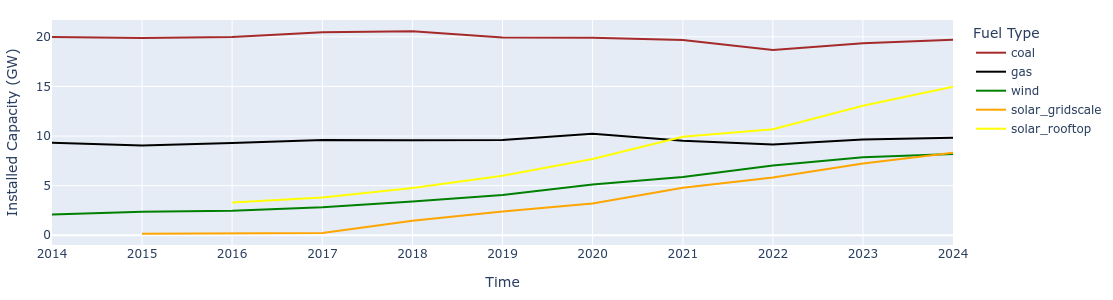

/tmp/ipykernel_2222/3738308276.py:27: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




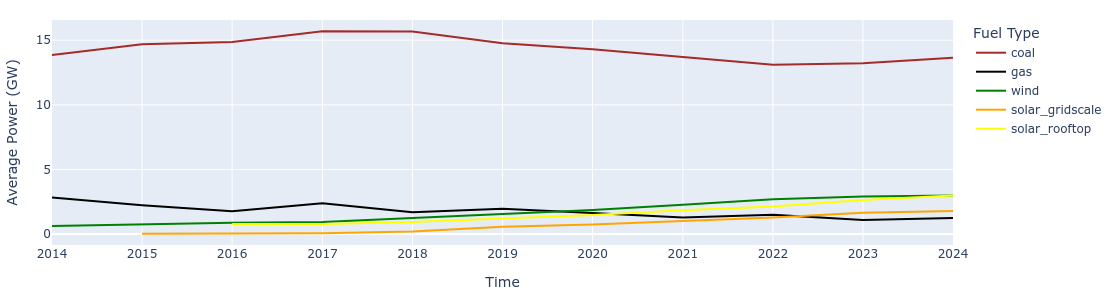

/tmp/ipykernel_2222/3738308276.py:27: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




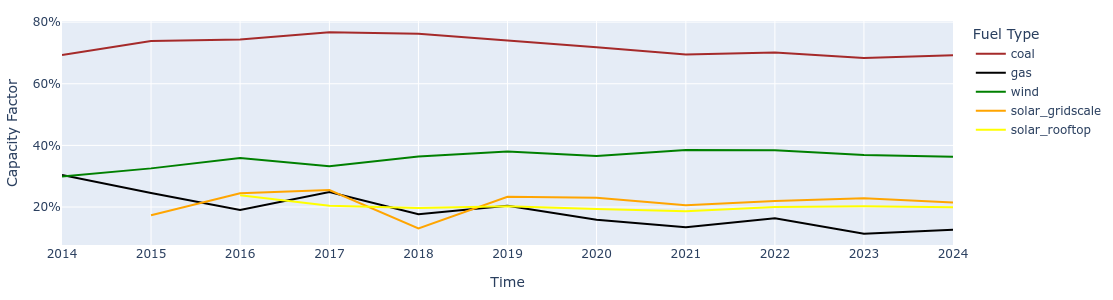

In [193]:
for (y, pc) in [("CAPACITY_GW", False), ("POWER_GW", False), ("CAPACITY_FACTOR", True)]:
    fig = px.line(
        results_df.filter(pl.col("FUEL_TYPE").is_in(color_mapping)),
        x="INTERVAL_START",
        y=y,
        color="FUEL_TYPE",
        color_discrete_map=color_mapping,
        height=300,
        width=300,
        labels={
            "FUEL_TYPE": "Fuel Type",
            "INTERVAL_START": "Time",
            "CAPACITY_FACTOR": "Capacity Factor",
            "CAPACITY": "Installed Capacity (MW)",
            "CAPACITY_GW": "Installed Capacity (GW)",
            "POWER_MW": "Average Power (MW)",
            "POWER_GW": "Average Power (GW)",
        }
    )
    if pc:
        fig.update_layout(yaxis_tickformat = '.0%')
        
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.update_layout(showlegend=False)
    fig.update_layout(margin=dict(l=20, r=20, t=20, b=20))
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
    fig.write_image(os.path.join(results_dir, f"{y}.svg"))
    fig.update_layout(showlegend=True)
    fig.show()

    figures[y] = fig